In [1]:
%reload_ext autoreload
%autoreload
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
import os

In [3]:
torch.cuda.set_device(1)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [5]:
path = Path('data/chest_xray/')
path_hr = Path('data/chest_xray/images')
path_lr = Path('data/chest_xray/crappy')
path_reverse = Path('data/chest_xray/pred_reverse')
bs = 64

torch.Size([3, 1801, 2078])


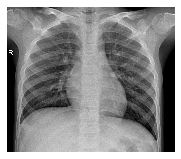

In [5]:
asda = open_image(path_hr/'IM-0684-0001.jpeg')
print(asda.data.shape)
asda.show()

In [6]:
from fastai.vision import *
import random, string
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        font = ImageFont.truetype('arial.ttf', 80)
        img = img.resize(img.size, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        names = []
        genders = ['M', 'F']
        with open(Path('names.txt')) as f:
            names= list(f)
        name = str(random.choice(names)) + " " + str(random.choice(names))
        ssn = random.randint(10000000000, 99999999999)
        age = "Age: " + str(random.randint(1, 150))
        sex = "Sex: " + random.choice(genders)
        data1 = str(random.randint(1, 9)) + "/" + str(9)
        data2 = "IM #:"
        data3 = "SE #:"
        data4 = "WL: W:" + str(random.randint(0,360)) + "L: " + str(random.randint(0, 360))
        q = ''.join(random.choice(string.ascii_lowercase) for i in range(random.randint(1, 8)))
        ImageDraw.Draw(img).text((0, 0), str(name), fill=(255,255,255), font=font) #first text
        ImageDraw.Draw(img).text((0, 150), str(age), fill=(255,255,255), font=font) #second text
        ImageDraw.Draw(img).text((0,300), str(sex), fill=(255,255,255), font=font) #third text
        ImageDraw.Draw(img).text((0,450), str(ssn), fill=(255,255,255), font=font) # fourth text
        ImageDraw.Draw(img).text((w//2, 0), str(name), fill=(255,255,255), font=font) #name right text
        recompute_scale_factor=True


        
        #ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//4)), str(q), fill=(255,255,255), font=font)
        #ImageDraw.Draw(img).text((0, h), str(data4), font=font) #bottom first text
        #ImageDraw.Draw(img).text((0, h-150), str(data3), font=font) #bottom second text
        #ImageDraw.Draw(img).text((0, h-300), str(data2), fill=(255,255,255), font=font) #bottom third text
        #ImageDraw.Draw(img).text((0, h-450), str(data1), fill=(255,255,255), font=font) #bottom fourth text

        img.save(dest)

In [7]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learner.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_pred/names[i].name)
            i += 1

In [8]:
from PIL import Image, ImageDraw, ImageFont
from random import randint

In [9]:
il = ImageList.from_folder(path_hr)

In [10]:
parallel(crappifier(path_lr, path_hr), il.items)

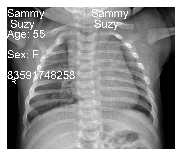

In [11]:
asdasa = open_image(path_lr/'IM-0675-0001.jpeg')
asdasa.show()

In [6]:
#bs,size=32, 128
#bs,size = 24,160
#bs,size = 8, 256
arch = models.resnet34

In [13]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [14]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform( size=size, tfm_y=True, resize_method=ResizeMethod.SQUISH)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [15]:
bs,size = 32,64
data = get_data(bs, size)

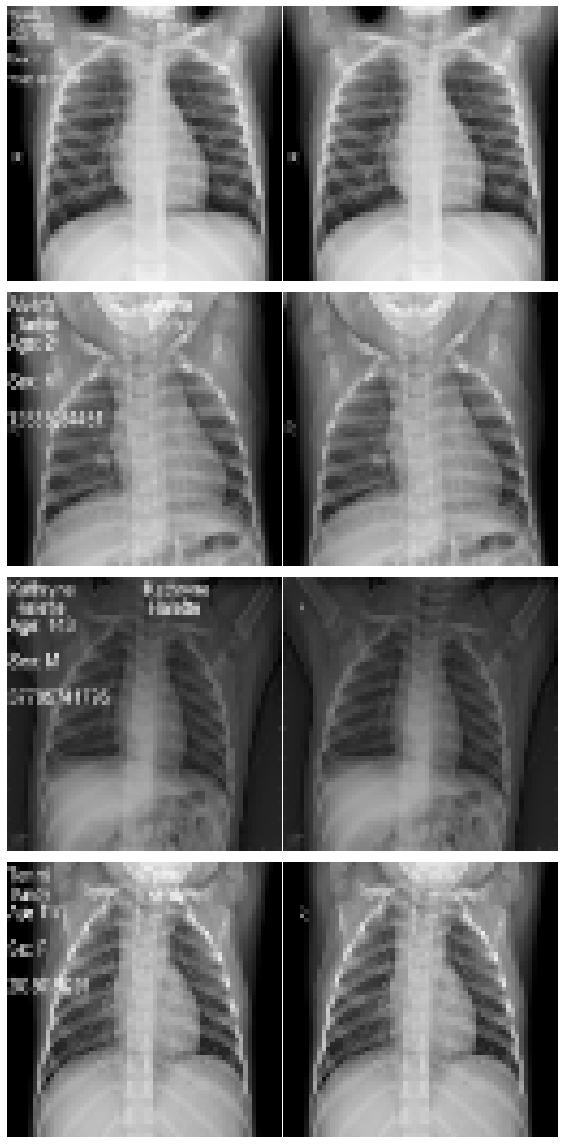

In [16]:
data.show_batch(4)

In [7]:
wd = 1e-3

In [8]:
y_range = (-3.,3.)

In [9]:
loss_gen = MSELossFlat()

In [10]:
def create_gen_learner():
    return unet_learner(data, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [21]:
learner = create_gen_learner()

In [22]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 9.12E-02


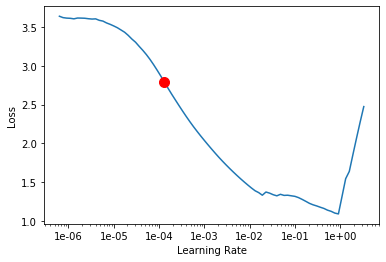

In [23]:
learner.recorder.plot(suggestion=True)

In [24]:
min_grad_lr = learner.recorder.min_grad_lr

learner.fit_one_cycle(2, min_grad_lr, pct_start=0.8)

In [25]:
learner.unfreeze()

In [26]:
learner.fit_one_cycle(10, slice(1e-5,1e-3))

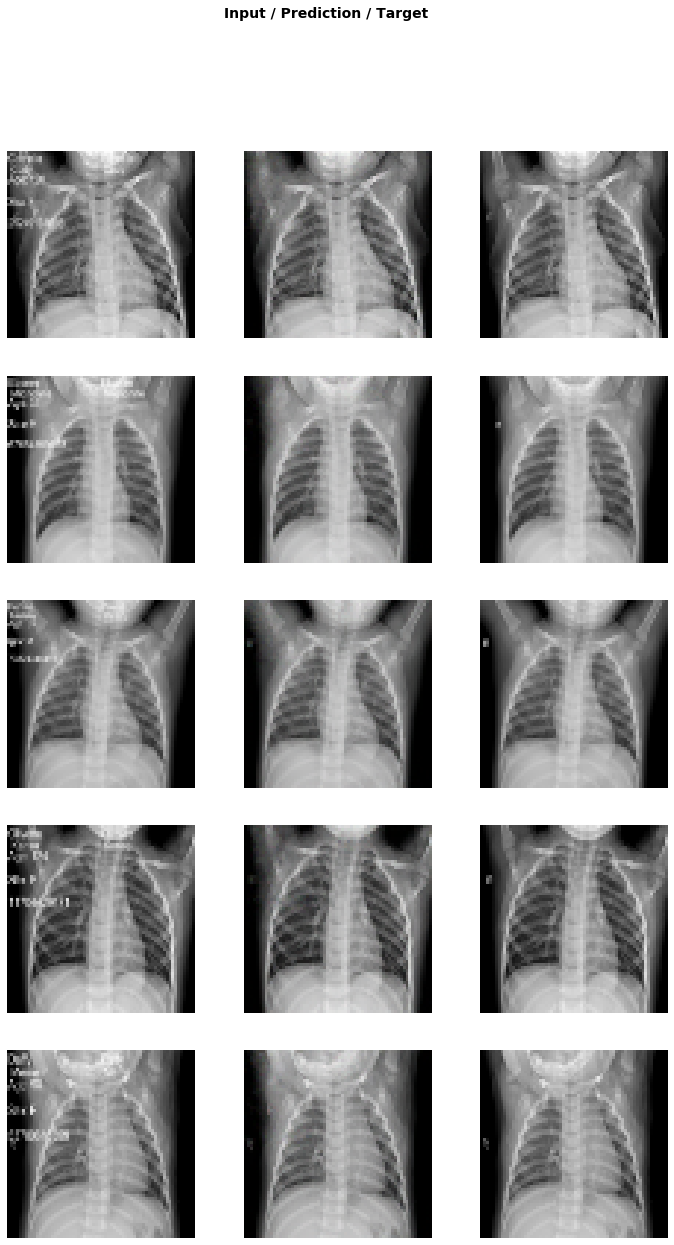

In [27]:
learner.show_results(rows=5)

In [28]:
learner.validate()

[0.0038317642]

In [29]:
learner.save('64')

In [30]:
torch.cuda.empty_cache()

In [31]:
gc.collect()

38376

In [32]:
data = get_data(16, 128)

In [33]:
learner = create_gen_learner().load('64')

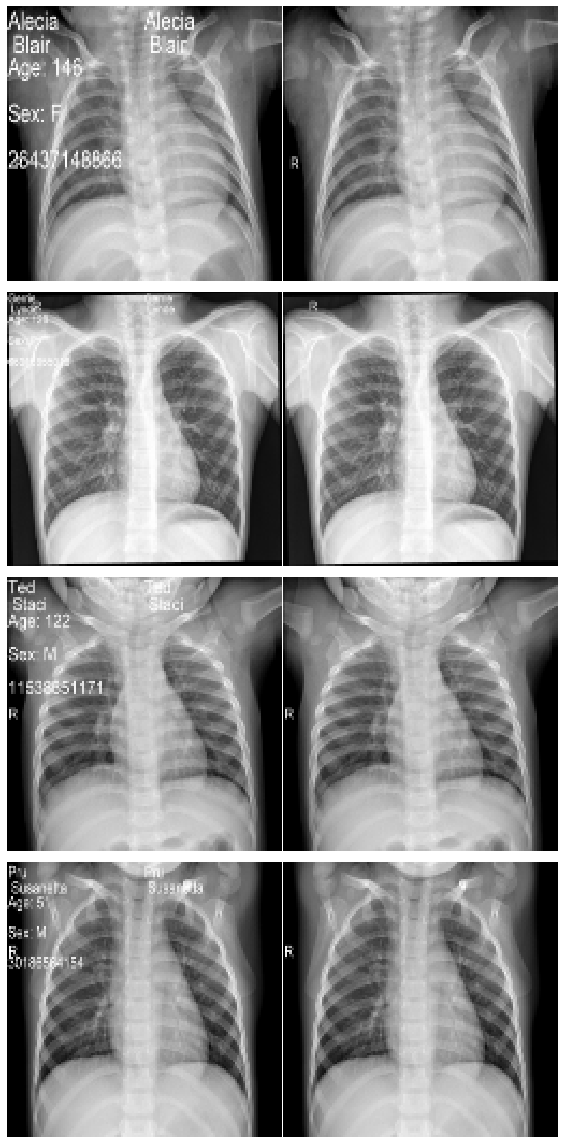

In [34]:
data.show_batch(4)

In [35]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-05


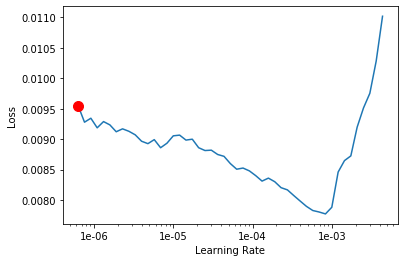

In [36]:
learner.recorder.plot(suggestion=True)

In [37]:
learner.unfreeze()

In [38]:
learner.fit_one_cycle(10, learner.recorder.min_grad_lr)

In [39]:
learner.save('128')

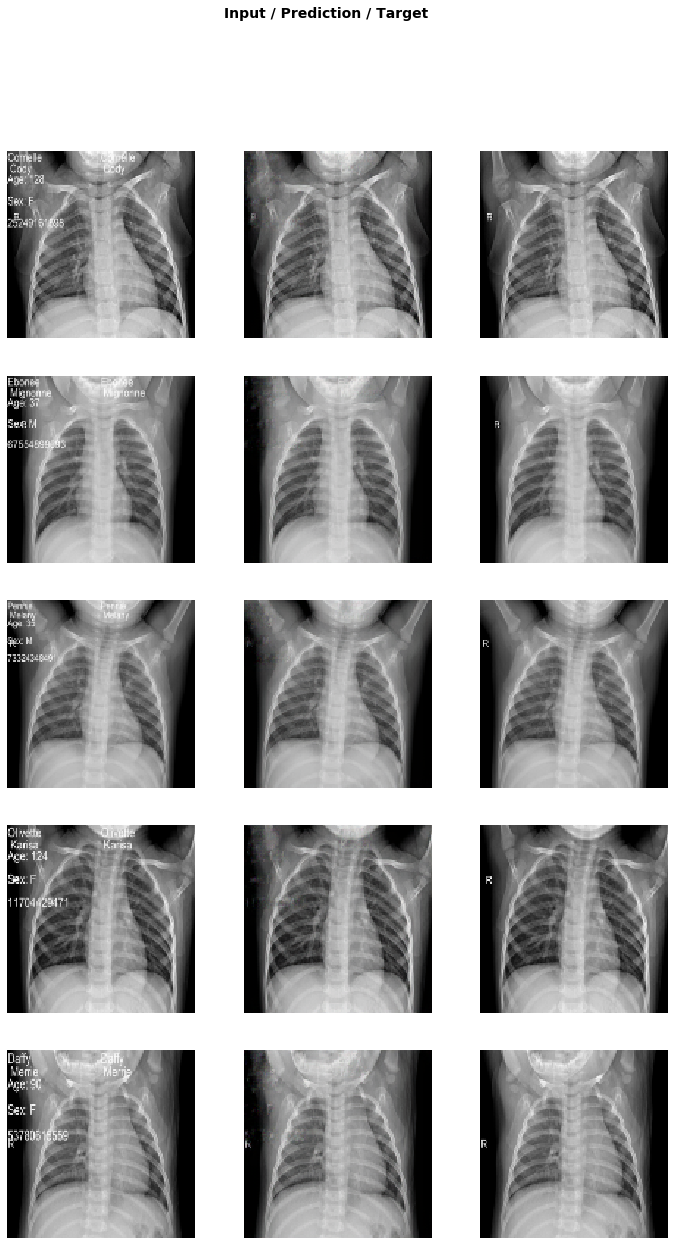

In [40]:
learner.show_results(rows=5)

In [41]:
gc.collect()

38321

In [42]:
data=get_data(8,256)

In [43]:
learner = create_gen_learner().load('128')

In [44]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 2.51E-04


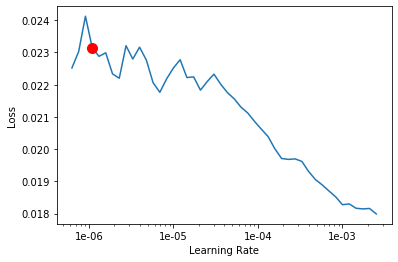

In [45]:
learner.recorder.plot(suggestion=True)

In [46]:
learner.unfreeze()

In [47]:
learner.fit_one_cycle(10, learner.recorder.min_grad_lr)

In [48]:
learner.save('256')

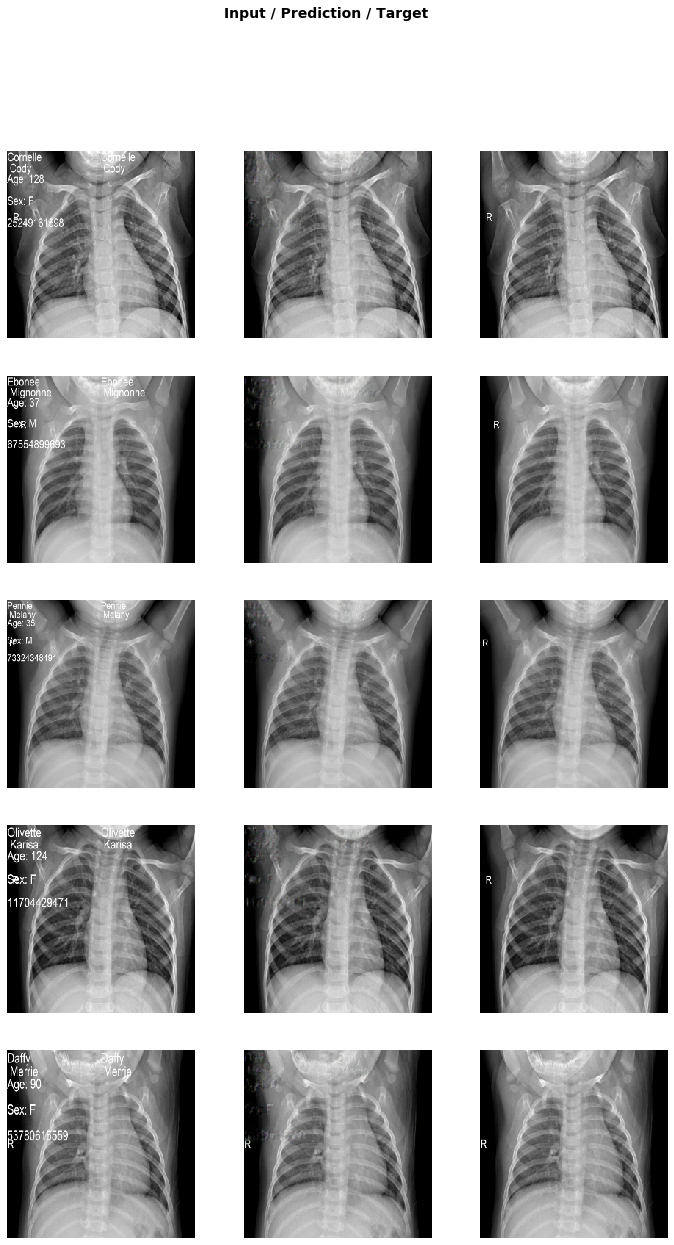

In [49]:
learner.show_results(rows=5)

In [50]:
gc.collect()

37542

In [51]:
data=get_data(4,512)

In [52]:
learner=create_gen_learner().load('256')

In [53]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07
Min loss divided by 10: 2.29E-07


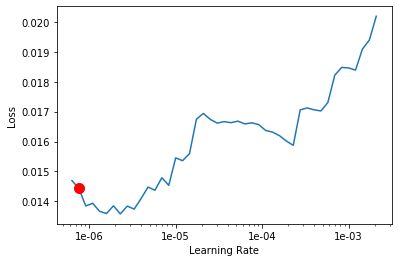

In [54]:
learner.recorder.plot(suggestion=True)

In [55]:
learner.fit_one_cycle(8, learner.recorder.min_grad_lr)

In [56]:
learner.save('512')

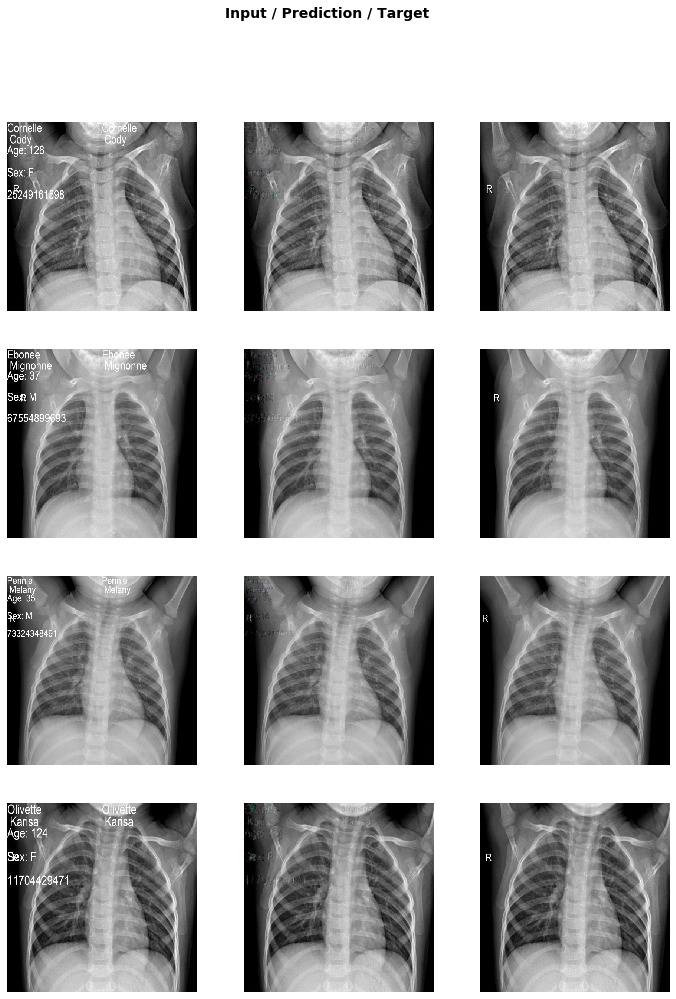

In [57]:
learner.show_results(rows=5)

In [58]:
gc.collect()

31266

In [59]:
data = get_data(2, 1024)

In [60]:
learner = create_gen_learner().load('512')

In [61]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-06
Min loss divided by 10: 7.59E-08


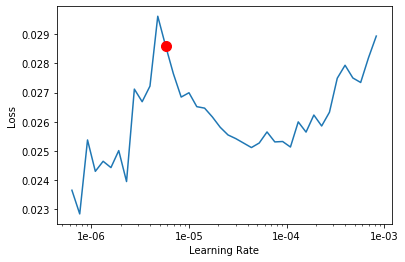

In [62]:
learner.recorder.plot(suggestion=True)

In [63]:
learner.unfreeze()

In [64]:
learner.fit_one_cycle(8, learner.recorder.min_grad_lr)

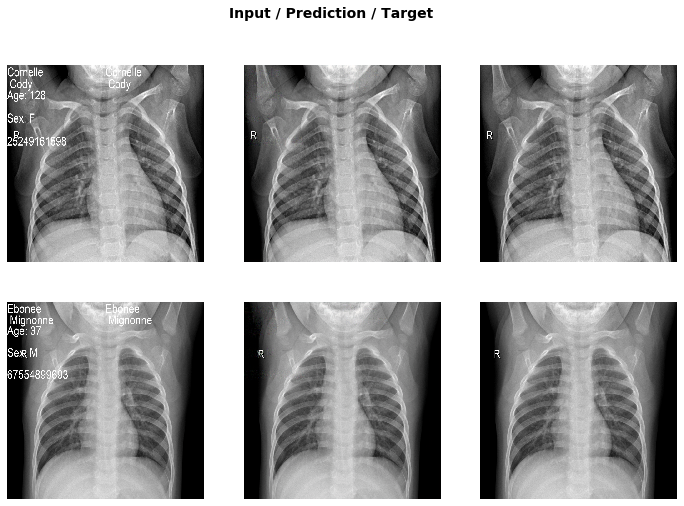

In [65]:
learner.show_results(rows=5)

In [12]:
name_pred = 'pred'
path_pred = path/name_pred

In [67]:
path_pred.mkdir(exist_ok=True)

In [68]:
save_preds(data.fix_dl)

In [69]:
learner.save('1024')

In [70]:
gc.collect()

18663

In [13]:
src = ImageImageList.from_folder(path_pred).split_by_rand_pct(0.1, seed=42)

In [14]:
def get_data2(bs,size):
    data = (src.label_from_func(lambda x: path_lr/x.name)
           .transform( size=size, tfm_y=True, resize_method=ResizeMethod.SQUISH)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

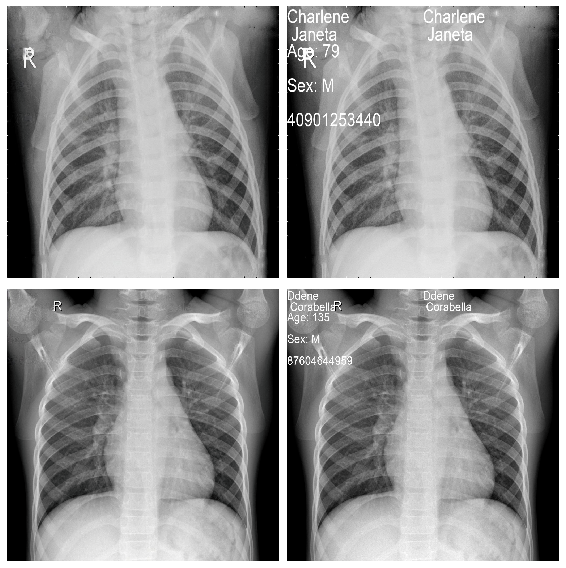

In [15]:
data = get_data2(2,1024)
data.show_batch(4)

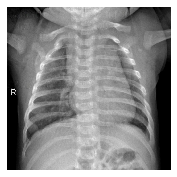

In [11]:
pic_preview = open_image(path_pred/'IM-0675-0001.jpeg')
pic_preview.show()

In [16]:
#learner = create_gen_learner().load('1024')
learner = create_gen_learner()
learner.data=data

In [17]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 3.98E-03


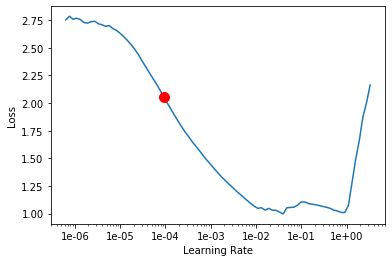

In [18]:
learner.recorder.plot(suggestion=True)

In [19]:
learner.unfreeze()

In [20]:
learner.fit_one_cycle(3, slice(1e-5,1e-2))

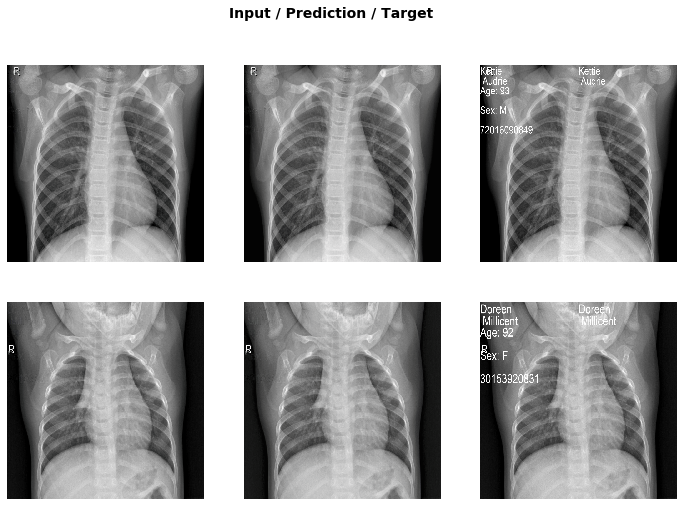

In [21]:
learner.show_results(rows=5)

In [81]:
learner.save('test_prediction')

In [82]:
name_pred_reverse = 'pred_reverse'
path_pred_reverse = path/name_pred_reverse

In [83]:
path_pred_reverse.mkdir(exist_ok=True)

In [84]:
def save_preds_reverse(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learner.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_pred_reverse/names[i].name)
            i += 1

In [85]:
save_preds_reverse(data.fix_dl)